In [1]:
import numpy as np

import rasterio
from rasterio import Affine
from rasterio.windows import Window
from rasterio.transform import from_bounds

from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from skimage.transform import rescale, resize

In [2]:
COG_URL = Path('/media/splash/00F2D259F2D25310/Data/final/arid.tif')

In [3]:
def get_windows(rst_h, rst_w, max_h, max_w, col_off = 0, row_off = 0):
    wins = []
    rows = rst_h // max_h + 1
    cols = rst_w // max_w + 1    
    
    for r in range(rows):
        if r == rows-1: height = rst_h % max_h
        else: height = max_h
            
        for c in range(cols):
            if c == cols-1: width = rst_w % max_w
            else: width = max_w

            if width != 0 and height != 0: 
                wins.append(((r,c),Window(c*max_w+col_off, r*max_h+row_off, width, height)))
    return wins

In [4]:
def get_tfm(window, rst_full):
    c_o, r_o, w, h = window.flatten()
    left, top, right, bottom = *rst_full.xy(r_o, c_o, offset='ul'), *rst_full.xy(r_o+h, c_o+w, offset='lr')
    tfm = from_bounds(left,bottom,right,top, w, h)
    return tfm

In [5]:
def save_subwin(arr, crs, tfm, save_fn):
    im = (arr*255).astype('uint8')
    with rasterio.open(OUTPUT/f'{save_fn}.tif', 'w', driver='GTiff', 
                            height=im.shape[0], width=im.shape[1],
                            count=3, dtype=im.dtype, crs=crs, transform=tfm, compress='JPEG', tiled=True) as dst:
        for k, a in [(1, im), (2, im), (3, im)]:
            dst.write(a, indexes=k)

In [6]:
def pad_window(window, pad):
    col_off, row_off, width, height = window.flatten()
    return Window(col_off-pad//2, row_off-pad//2,width+pad,height+pad)

In [7]:
OUTPUT = Path('/media/splash/00F2D259F2D25310/Data/final/outputs')

In [8]:
raster = rasterio.open(COG_URL,'r')
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 6431,
 'height': 6503,
 'count': 3,
 'crs': CRS.from_epsg(3785),
 'transform': Affine(0.1492910708695108, 0.0, 8135024.072190155,
        0.0, -0.14929107086944654, 3982066.4113659593)}

In [9]:
from fastai.vision import *

path = Path('/media/splash/00F2D259F2D25310/Data/final')
path_lbl = path/'labels'
path_img = path/'images'
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'
codes = np.array(['Empty','Building'])
unet_sz = 768
bs=1

data = (SegmentationItemList.from_folder(path_img)
        .random_split_by_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=unet_sz)
        .databunch(bs=bs)
        .normalize(imagenet_stats))        

learn = unet_learner(data, models.resnet34)
learn.load('20190108-rn34unet-comboloss-alldata-224-unfreeze-best')
learn.model.eval()

/home/splash/anaconda3/envs/fastai1/lib/python3.7/site-packages/fastai/data_block.py:212: UserWarning: `random_split_by_pct` is deprecated, please use `split_by_rand_pct`.
  warn("`random_split_by_pct` is deprecated, please use `split_by_rand_pct`.")


DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [10]:
def get_pred(learn, tile):
    t_img = Image(pil2tensor(tile,np.float32))
    outputs = learn.predict(t_img)
    im = (outputs[2][1]).numpy()
    return im

# Run inference on subwindows of windows and save raster

In [12]:
tif_sz = 6503 
tile_sz = 512
pad_sz = tile_sz//2
pred_sz = tile_sz+pad_sz

print(tile_sz, pad_sz, pred_sz)
assert pred_sz == unet_sz

scale_factor = 1
save_prefix = f'arid{scale_factor}x'

512 256 768


In [13]:
tile_scaled = tile_sz*scale_factor
pad_scaled = pad_sz*scale_factor
test_wins = get_windows(raster.meta['height'], raster.meta['width'], tif_sz, tif_sz)

print(len(test_wins))
for idx, win in enumerate(test_wins):
    print(idx, win)
    
    # make subwindows and blank array to fill in
    col_off, row_off, rst_w, rst_h = win[1].flatten()
    sub_wins = get_windows(rst_h, rst_w, tile_scaled, tile_scaled, col_off, row_off)
    new_arr = np.zeros((rst_h, rst_w))

    for (row_idx, col_idx), window in tqdm(sub_wins):
        win_padded = pad_window(window, pad_scaled)
        win_img = np.rollaxis(raster.read(window=win_padded, boundless=True),0,3)/255

        # scale down windowed read to unet input size
        win_img = rescale(win_img,1/scale_factor,anti_aliasing=False)
        placeholder = np.zeros((pred_sz,pred_sz,3))
        placeholder[:win_img.shape[0],:win_img.shape[1]] = win_img
        
        # skip inference if empty window
        if placeholder.max() > 0: pr = get_pred(learn, placeholder)
        else: pr = placeholder[:,:,0]
        
        # scale back up to original tile size to fill into blank array at right place
        pr = rescale(pr, scale_factor, anti_aliasing=False)
        pr = pr[pad_scaled//2:-pad_scaled//2,pad_scaled//2:-pad_scaled//2]

        try: 
            width, height = window.flatten()[-2:]
            start_y = row_idx*tile_scaled
            start_x = col_idx*tile_scaled
            new_arr[start_y:start_y+height, start_x:start_x+width]= pr[:height,:width]
        except Exception as exc: print(f'{exc}')
    
    tfm = get_tfm(win[1], raster)
    save_subwin(new_arr, raster.meta['crs'].data['init'], tfm, f'{save_prefix}_id{idx}')

  0%|          | 0/169 [00:00<?, ?it/s]

1
0 ((0, 0), Window(col_off=0, row_off=0, width=6431, height=6503))


/home/splash/anaconda3/envs/fastai1/lib/python3.7/site-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
100%|██████████| 169/169 [01:12<00:00,  2.86it/s]


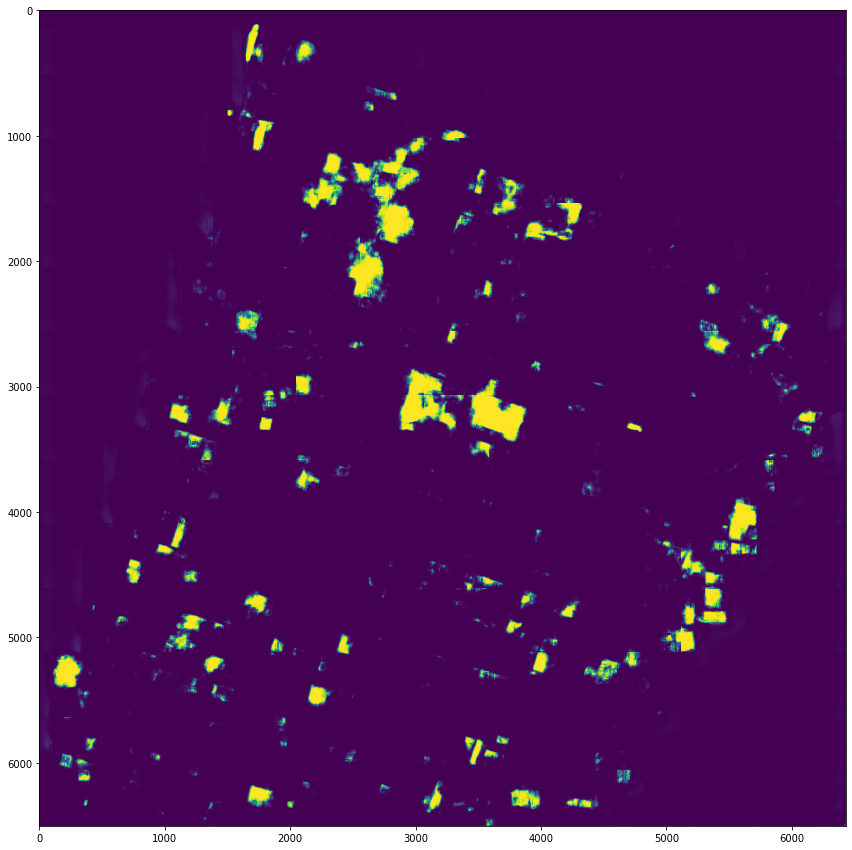

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(new_arr)

## Merge rasters

In [15]:
from rasterio.merge import merge

In [16]:
fns = sorted([o.name for o in OUTPUT.iterdir() if save_prefix in o.name])

In [17]:
fns

['arid1x_id0.tif']

In [18]:
src_files_to_mosaic = []

for fn in fns:
    src = rasterio.open(OUTPUT/fn)
    src_files_to_mosaic.append(src)

In [19]:
mosaic, out_tfm = merge(src_files_to_mosaic)

In [20]:
out_tfm, mosaic.shape

(Affine(0.14931428515517545, 0.0, 8135024.072190155,
        0.0, -0.14931402813080957, 3982066.4113659593), (3, 6503, 6431))

In [21]:
out_meta = src.meta.copy()
out_meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 6431,
 'height': 6503,
 'count': 3,
 'crs': CRS.from_epsg(3785),
 'transform': Affine(0.14931428515517545, 0.0, 8135024.072190155,
        0.0, -0.14931402813080957, 3982066.4113659593)}

In [22]:
out_meta.update({"driver": "GTiff",
                 "count:":1,
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_tfm,
                 "compress": "jpeg",
                 "tiled": True
                })

In [23]:
with rasterio.open(OUTPUT/f'{save_prefix}_merged.tif', "w", **out_meta) as dest:
    dest.write(mosaic)